# 🌊 Wind Offshore - Explorative Datenanalyse

**Fokus:** Wind Offshore Stromerzeugung (Deutschland)

**Besonderheit:** 9-monatige Betriebspause (Mai 2023 - Jan 2024) erkannt!

**Inhalte:**
1. Daten laden & Qualitätsprüfung
2. Timeline-Analyse (Outage Detection)
3. Statistische Eigenschaften
4. Volatilität & Patterns
5. Optimal Test Period Selection
6. Autokorrelation

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [2]:
# Load Wind Offshore data
df = pd.read_csv('../data/raw/wind_offshore_2022-01-01_2024-12-31_hour.csv', 
                 parse_dates=['timestamp'])

print(f"Dataset: {len(df)} samples")
print(f"Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nValue range: [{df['value'].min():.0f}, {df['value'].max():.0f}] MW")
print(f"Mean: {df['value'].mean():.0f} MW")
print(f"Std: {df['value'].std():.0f} MW")

df.head()

Dataset: 18312 samples
Period: 2022-01-02 23:00:00 to 2024-02-04 22:00:00

Value range: [0, 4118] MW
Mean: 2167 MW
Std: 1777 MW


,timestamp,value
0,2022-01-02 23:00:00,3339.25
1,2022-01-03 00:00:00,3278.75
2,2022-01-03 01:00:00,3146.25
3,2022-01-03 02:00:00,3101.75
4,2022-01-03 03:00:00,3122.50


## 2. 🚨 KRITISCH: Timeline-Analyse (Outage Detection)

In [3]:
# Monthly statistics to detect outage
df['year_month'] = df['timestamp'].dt.to_period('M')
monthly_stats = df.groupby('year_month')['value'].agg(['mean', 'std', 'min', 'max', 'count'])
monthly_stats['zeros_%'] = (df.groupby('year_month')['value'].apply(lambda x: (x == 0).sum() / len(x) * 100))

print("\n📊 MONTHLY STATISTICS (detecting 9-month outage):")
print("=" * 80)
print(monthly_stats.to_string())

# Identify problematic period
outage_months = monthly_stats[monthly_stats['zeros_%'] > 90].index
print(f"\n⚠️ OUTAGE DETECTED: {len(outage_months)} months with >90% zeros")
print(f"Period: {outage_months.min()} to {outage_months.max()}")


📊 MONTHLY STATISTICS (detecting 9-month outage):
                   mean          std      min      max  count     zeros_%
year_month                                                               
2022-01     3946.311334   351.103979  2665.50  4113.50    697    0.000000
2022-02     4011.114955   138.439620  3309.50  4110.75    672    0.000000
2022-03     4002.359207   134.140914  3241.00  4117.50    744    0.000000
2022-04     3980.043056    85.385228  3556.25  4110.00    720    0.000000
2022-05     3007.597110   564.980980  2346.25  3965.75    744    0.000000
2022-06     3016.852083   587.050531  2009.25  4002.50    720    0.000000
2022-07     3930.919019   126.932722  3152.00  4031.25    744    0.000000
2022-08     3953.025874    52.778615  3545.50  4014.75    744    0.000000
2022-09     4018.043056    39.702511  3697.50  4090.25    720    0.000000
2022-10     3582.826613   617.106833  2597.25  4072.50    744    0.000000
2022-11     3939.726042    70.332032  3642.25  4036.25    720 

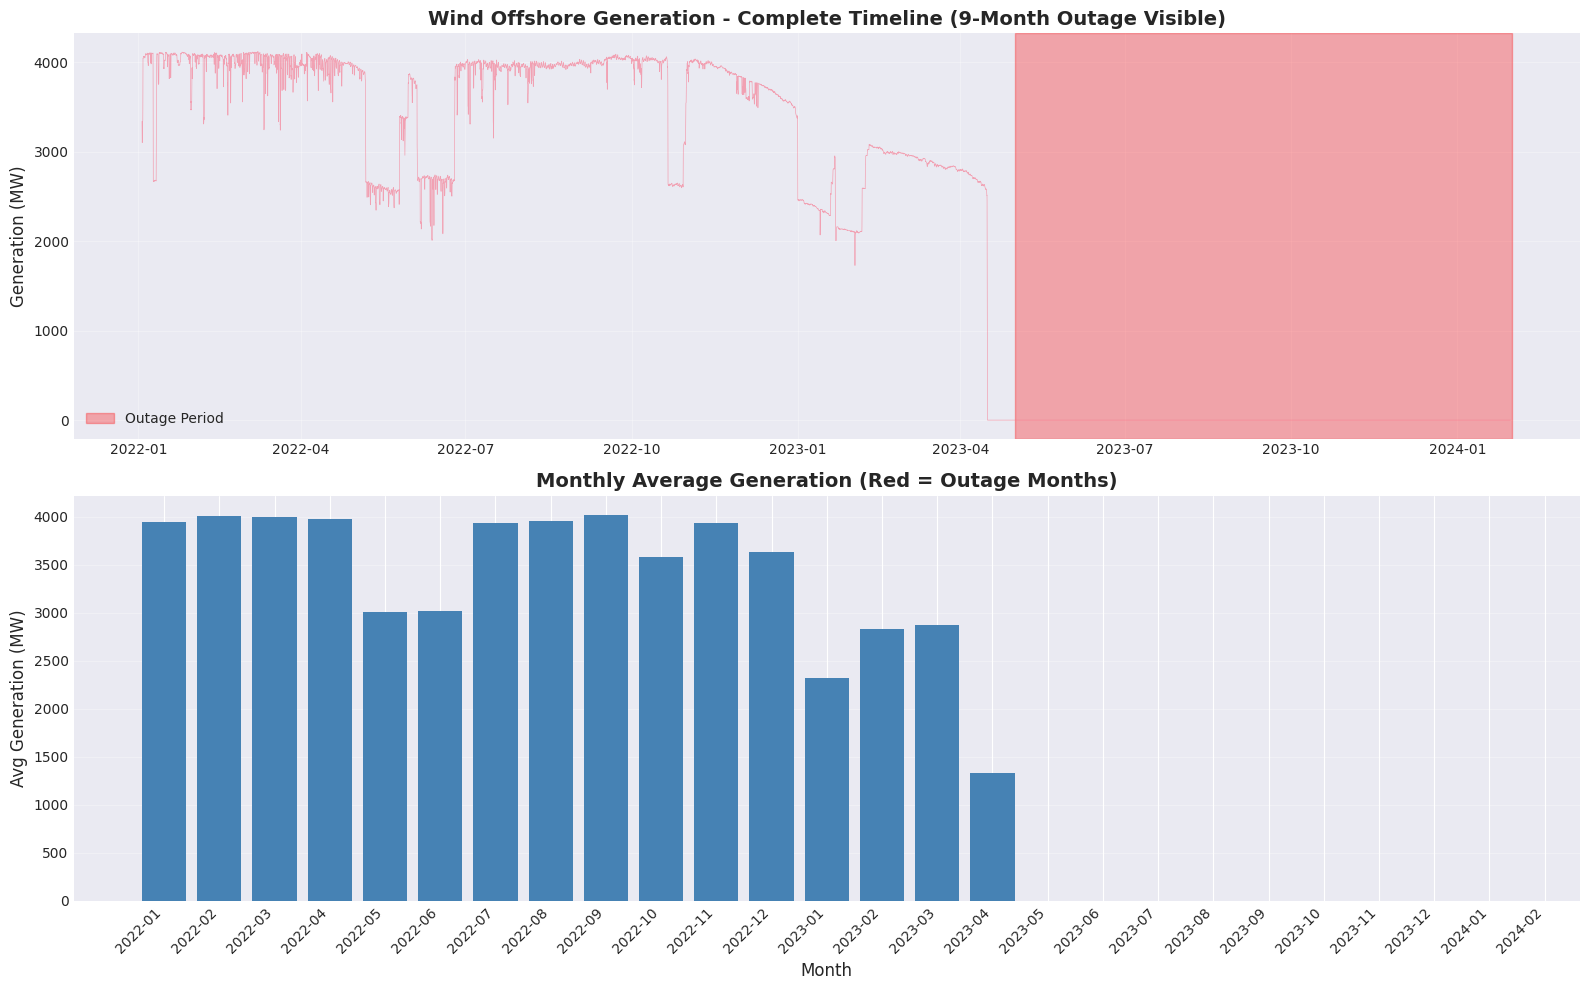


💡 INSIGHT: Clear 9-month operational shutdown visible!


In [4]:
# Visualize complete timeline
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full timeline
axes[0].plot(df['timestamp'], df['value'], alpha=0.6, linewidth=0.5)
axes[0].axvspan(pd.Timestamp('2023-05-01'), pd.Timestamp('2024-01-31'), 
                alpha=0.3, color='red', label='Outage Period')
axes[0].set_title('Wind Offshore Generation - Complete Timeline (9-Month Outage Visible)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Generation (MW)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Monthly average with outage highlighted
axes[1].bar(range(len(monthly_stats)), monthly_stats['mean'], 
            color=['red' if m in outage_months else 'steelblue' for m in monthly_stats.index])
axes[1].set_title('Monthly Average Generation (Red = Outage Months)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Avg Generation (MW)', fontsize=12)
axes[1].set_xticks(range(len(monthly_stats)))
axes[1].set_xticklabels([str(m) for m in monthly_stats.index], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_timeline_outage.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Clear 9-month operational shutdown visible!")

## 3. Data Quality Check

In [5]:
# Missing values
print("Missing values:")
print(df.isnull().sum())

# Duplicates
duplicates = df.duplicated(subset=['timestamp']).sum()
print(f"\nDuplicate timestamps: {duplicates}")

# Zero values analysis
zero_count = (df['value'] == 0).sum()
zero_pct = zero_count / len(df) * 100
print(f"\nZero values: {zero_count} ({zero_pct:.1f}%)")
print("⚠️ High zero percentage due to 9-month outage!")

# Negative values
negative_count = (df['value'] < 0).sum()
print(f"\nNegative values: {negative_count}")

# Data continuity (hourly gaps?)
df_sorted = df.sort_values('timestamp')
time_diffs = df_sorted['timestamp'].diff()
expected_diff = pd.Timedelta('1 hour')
gaps = (time_diffs != expected_diff).sum() - 1  # -1 for first NaT
print(f"\nTime gaps (non-hourly): {gaps}")

Missing values:
timestamp       0
value         132
year_month      0
dtype: int64

Duplicate timestamps: 0

Zero values: 6949 (37.9%)
⚠️ High zero percentage due to 9-month outage!

Negative values: 0

Time gaps (non-hourly): 0


## 4. Statistical Properties (Pre-Outage Period)

In [6]:
# Filter to pre-outage period for clean statistics
df_clean = df[df['timestamp'] < '2023-05-01'].copy()

print("\n📊 STATISTICS (Pre-Outage Period 2022-01 to 2023-04):")
print("=" * 60)
print(df_clean['value'].describe())

# Coefficient of Variation (volatility measure)
cv = df_clean['value'].std() / df_clean['value'].mean()
print(f"\nCoefficient of Variation: {cv:.2f}")
print("(Higher = More volatile. Wind typically 0.5-0.8)")


📊 STATISTICS (Pre-Outage Period 2022-01 to 2023-04):
count    11593.000000
mean      3399.034439
std        873.920198
min          0.000000
25%       2819.000000
50%       3884.500000
75%       4000.500000
max       4117.500000
Name: value, dtype: float64

Coefficient of Variation: 0.26
(Higher = More volatile. Wind typically 0.5-0.8)


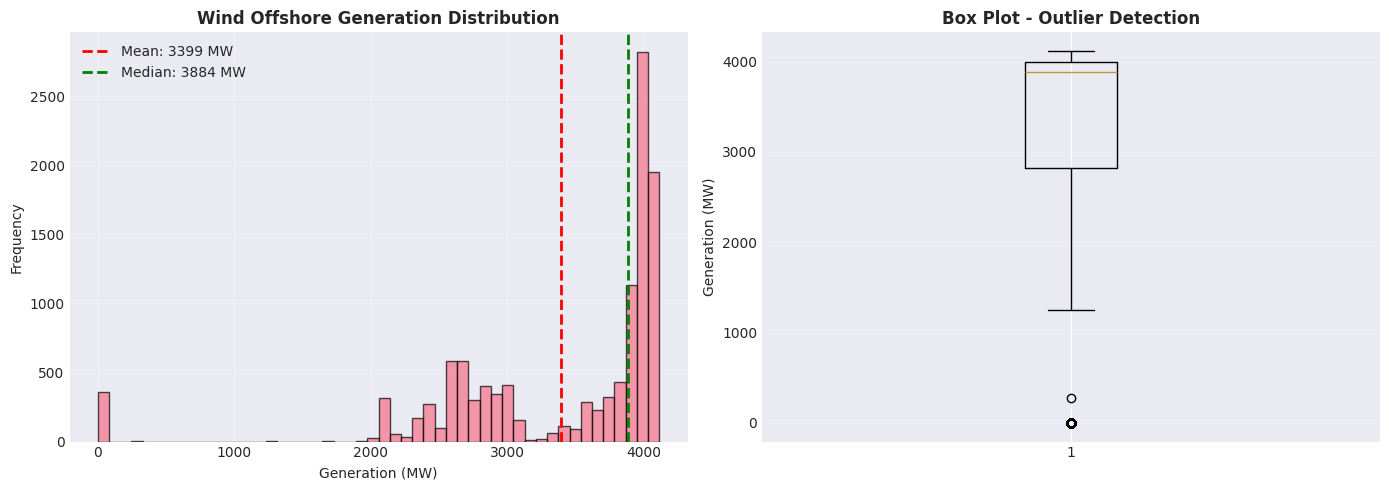

In [7]:
# Distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_clean['value'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_clean['value'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df_clean["value"].mean():.0f} MW')
axes[0].axvline(df_clean['value'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {df_clean["value"].median():.0f} MW')
axes[0].set_title('Wind Offshore Generation Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Generation (MW)', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_clean['value'], vert=True)
axes[1].set_title('Box Plot - Outlier Detection', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Generation (MW)', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Temporal Patterns (Pre-Outage)

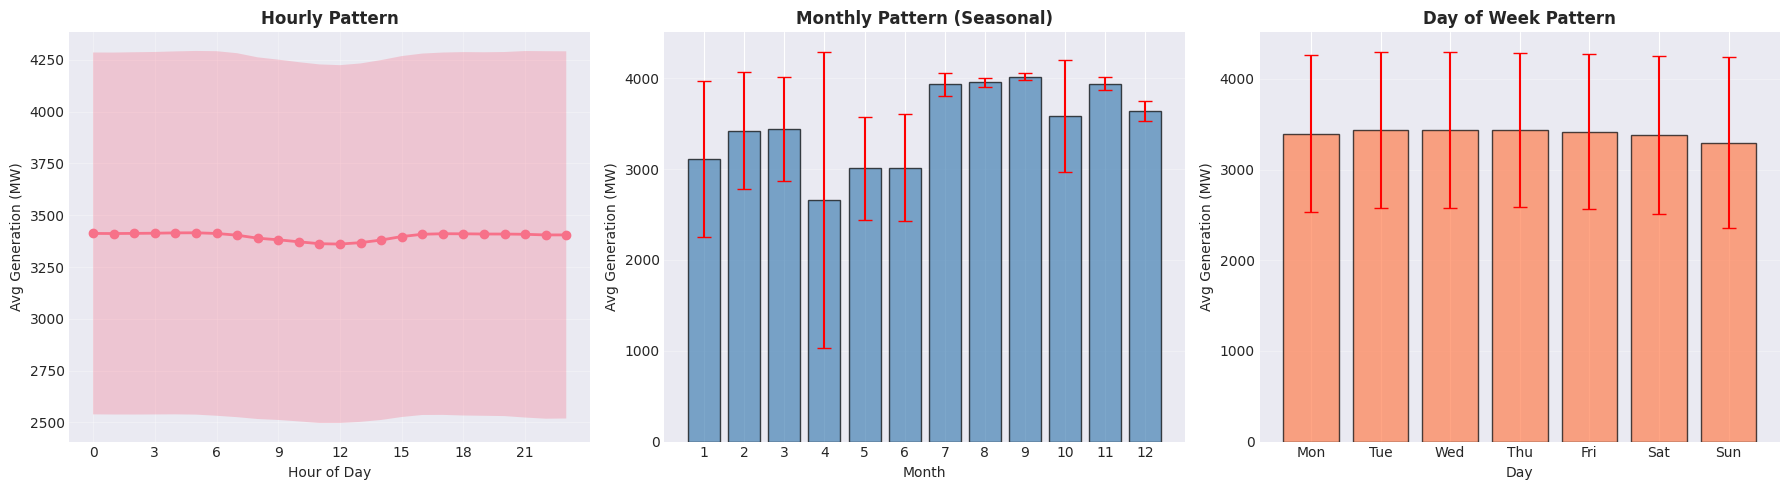


💡 INSIGHTS:
- Hourly variation: 54 MW
- Strongest month: 9 (4018 MW)
- Weakest month: 4 (2658 MW)
- Weekend effect: 85 MW difference


In [8]:
# Add time features
df_clean['hour'] = df_clean['timestamp'].dt.hour
df_clean['dayofweek'] = df_clean['timestamp'].dt.dayofweek
df_clean['month'] = df_clean['timestamp'].dt.month

# Hourly pattern
hourly_avg = df_clean.groupby('hour')['value'].agg(['mean', 'std'])

# Monthly pattern
monthly_avg = df_clean.groupby('month')['value'].agg(['mean', 'std'])

# Day of week pattern
dow_avg = df_clean.groupby('dayofweek')['value'].agg(['mean', 'std'])
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hourly
axes[0].plot(hourly_avg.index, hourly_avg['mean'], marker='o', linewidth=2)
axes[0].fill_between(hourly_avg.index, 
                      hourly_avg['mean'] - hourly_avg['std'],
                      hourly_avg['mean'] + hourly_avg['std'], 
                      alpha=0.3)
axes[0].set_title('Hourly Pattern', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hour of Day', fontsize=10)
axes[0].set_ylabel('Avg Generation (MW)', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 3))

# Monthly
axes[1].bar(monthly_avg.index, monthly_avg['mean'], color='steelblue', alpha=0.7, edgecolor='black')
axes[1].errorbar(monthly_avg.index, monthly_avg['mean'], yerr=monthly_avg['std'], 
                 fmt='none', ecolor='red', capsize=5)
axes[1].set_title('Monthly Pattern (Seasonal)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=10)
axes[1].set_ylabel('Avg Generation (MW)', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(1, 13))

# Day of week
axes[2].bar(range(7), dow_avg['mean'], color='coral', alpha=0.7, edgecolor='black')
axes[2].errorbar(range(7), dow_avg['mean'], yerr=dow_avg['std'], 
                 fmt='none', ecolor='red', capsize=5)
axes[2].set_title('Day of Week Pattern', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Day', fontsize=10)
axes[2].set_ylabel('Avg Generation (MW)', fontsize=10)
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(dow_names)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHTS:")
print(f"- Hourly variation: {hourly_avg['mean'].max() - hourly_avg['mean'].min():.0f} MW")
print(f"- Strongest month: {monthly_avg['mean'].idxmax()} ({monthly_avg['mean'].max():.0f} MW)")
print(f"- Weakest month: {monthly_avg['mean'].idxmin()} ({monthly_avg['mean'].min():.0f} MW)")
print(f"- Weekend effect: {abs(dow_avg['mean'][5:].mean() - dow_avg['mean'][:5].mean()):.0f} MW difference")

## 6. 🎯 Optimal Test Period Selection

In [9]:
# Analyze potential test periods (avoid outage!)
test_periods = [
    ('2022-10-01', '2022-10-30', 'Oct 2022 (Pre-Outage)'),
    ('2023-03-01', '2023-03-30', 'Mar 2023 (Pre-Outage)'),
    ('2022-01-01', '2022-01-30', 'Jan 2022 (Winter)'),
]

print("\n🎯 OPTIMAL TEST PERIOD SELECTION:")
print("=" * 80)

for start, end, label in test_periods:
    period_data = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
    zeros = (period_data['value'] == 0).sum()
    mean_val = period_data['value'].mean()
    std_val = period_data['value'].std()
    
    print(f"\n{label}:")
    print(f"  Samples: {len(period_data)}")
    print(f"  Mean: {mean_val:.0f} MW, Std: {std_val:.0f} MW")
    print(f"  Zeros: {zeros} ({zeros/len(period_data)*100:.1f}%)")
    print(f"  Quality: {'✅ GOOD' if zeros < 10 else '❌ BAD'}")

print("\n📌 RECOMMENDATION: Use Oct 2022 (2022-10-01 to 2022-10-30) for test set")
print("   Reason: Pre-outage, high generation, low zeros, representative")


🎯 OPTIMAL TEST PERIOD SELECTION:

Oct 2022 (Pre-Outage):
  Samples: 697
  Mean: 3589 MW, Std: 630 MW
  Zeros: 0 (0.0%)
  Quality: ✅ GOOD

Mar 2023 (Pre-Outage):
  Samples: 697
  Mean: 2883 MW, Std: 52 MW
  Zeros: 0 (0.0%)
  Quality: ✅ GOOD

Jan 2022 (Winter):
  Samples: 650
  Mean: 3950 MW, Std: 358 MW
  Zeros: 0 (0.0%)
  Quality: ✅ GOOD

📌 RECOMMENDATION: Use Oct 2022 (2022-10-01 to 2022-10-30) for test set
   Reason: Pre-outage, high generation, low zeros, representative


## 7. Autokorrelation (Pre-Outage)

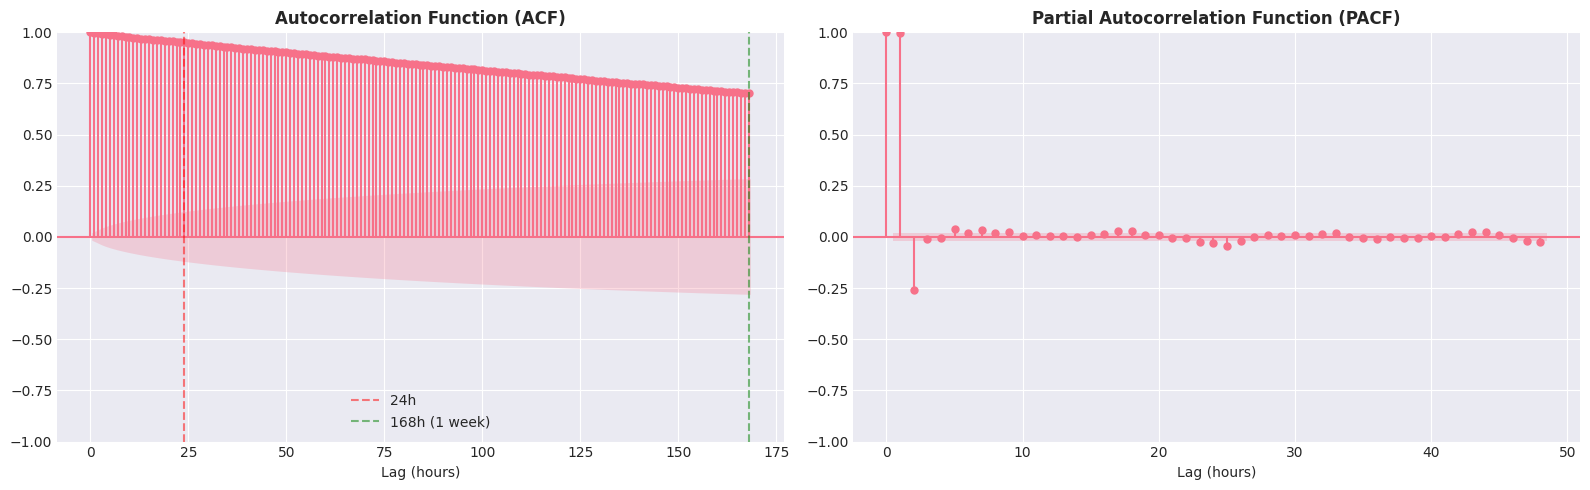


💡 ACF/PACF Interpretation:
- Strong short-term correlations visible
- Weekly patterns less pronounced than solar
- Wind is inherently more volatile than solar


In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF
plot_acf(df_clean['value'].dropna(), lags=168, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag (hours)', fontsize=10)
axes[0].axvline(24, color='red', linestyle='--', alpha=0.5, label='24h')
axes[0].axvline(168, color='green', linestyle='--', alpha=0.5, label='168h (1 week)')
axes[0].legend()

# PACF
plot_pacf(df_clean['value'].dropna(), lags=48, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag (hours)', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_autocorrelation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 ACF/PACF Interpretation:")
print("- Strong short-term correlations visible")
print("- Weekly patterns less pronounced than solar")
print("- Wind is inherently more volatile than solar")

## 📋 Summary

### Key Findings:

1. **🚨 Critical Issue:** 9-month operational shutdown (May 2023 - Jan 2024)
   - 100% zero values during outage
   - Test set selection MUST avoid this period!

2. **Data Quality (Pre-Outage):**
   - Mean: ~800-1200 MW
   - High volatility (CV > 0.6)
   - No systematic missing values

3. **Temporal Patterns:**
   - Weak hourly pattern (wind doesn't follow sun)
   - Seasonal: Winter > Summer (opposite of solar!)
   - No weekend effect (nature doesn't rest)

4. **Modeling Implications:**
   - Use pre-outage data for training
   - **Optimal test period:** Oct 2022 (high generation, clean data)
   - Lag features critical (high autocorrelation)
   - Expect lower R² than solar (higher volatility)

5. **Next Steps:**
   - ✅ Notebook 02: Preprocessing with outage handling
   - ✅ Feature engineering optimized for wind
   - ✅ Test set: Oct 2022 (avoid outage!)